
# Walkthrough

First let's import pylab, Meshoid, and the load_from_snapshot script for loading GIZMO outputs.

In [15]:
from matplotlib import pyplot as plt
import numpy as np
from meshoid import Meshoid
from load_from_snapshot import load_from_snapshot
%matplotlib inline

Now let's load some of the gas data fields from a snapshot in the public FIRE data release using load_from_snapshot. In this case we'll perform a density cut at n_H ~ .1 cm^-3 to narrow it down to just the ISM.

In [16]:
from os import system
from os.path import isfile

# download the data - feel free to use your own snapshots!
for i in range(4):
    if not isfile(f"./snapshot_600.{i}.hdf5"):
        system(f"wget -r -nH --cut-dirs=6 --no-parent --reject='index.html*' -e robots=off https://users.flatironinstitute.org/~chayward/fire2_public_release/core/m12i_res7100/output/snapdir_600/snapshot_600.{i}.hdf5")

rho = load_from_snapshot("Density", 0, ".", 600)
RHO_TO_NH = 300 # convert to H number density (approx)
density_cut = (rho*RHO_TO_NH > .01)
pdata = {}
fields_to_load = "Masses", "Coordinates", "SmoothingLength", "Velocities", "Density"
pdata = {field: load_from_snapshot(field, 0, ".", 600, particle_mask=np.arange(len(rho))[density_cut]) for field in fields_to_load}

Finally, before getting to the meshoid stuff we will also center the coordinates, perform a cut in galactocentric radius at 40kpc, and orient our coordinates to the principal axes of the gas distribution.

In [17]:
# do centering
pos = pdata["Coordinates"]
center = np.median(pos,axis=0)
pos -= center

# do radius cut
MAX_RADIUS = 40.
radius_cut = np.sum(pos*pos,axis=1) < MAX_RADIUS * MAX_RADIUS
pos, mass, hsml, v, rho = pos[radius_cut], pdata["Masses"][radius_cut], pdata["SmoothingLength"][radius_cut], pdata["Velocities"][radius_cut], pdata["Density"][radius_cut]
center_new = np.average(pos,axis=0,weights=mass) # now do another re-centering
center += center_new
pos -= center_new

# now get the principal axes - eigenvectors of the second mass moment matrix
cov_pos = np.cov(pos.T, aweights=mass)
w, coordinate_basis = np.linalg.eigh(cov_pos)
coordinate_basis = coordinate_basis[:,w.argsort()[::-1]] # sort so the smallest moment axis is the last = z-axis
pos = pos @ coordinate_basis # dot product with each basis vector to get coordinates in new basis

OK, now let's start by making a map of gas surface density. We can do so by generating a Meshoid object from the particle masses, coordinates, and smoothing lengths, and then calling the SurfaceDensity method. This function is useful for giving kernel-weighted projected quantities on a Cartesion grid of sighlines.

Meshoid can also adaptively compute particle smoothing lengths on-the-fly provided only the coordinates, but it requires a nearest-neighbor search that takes a while so it's best to provide the smoothing length when you can.

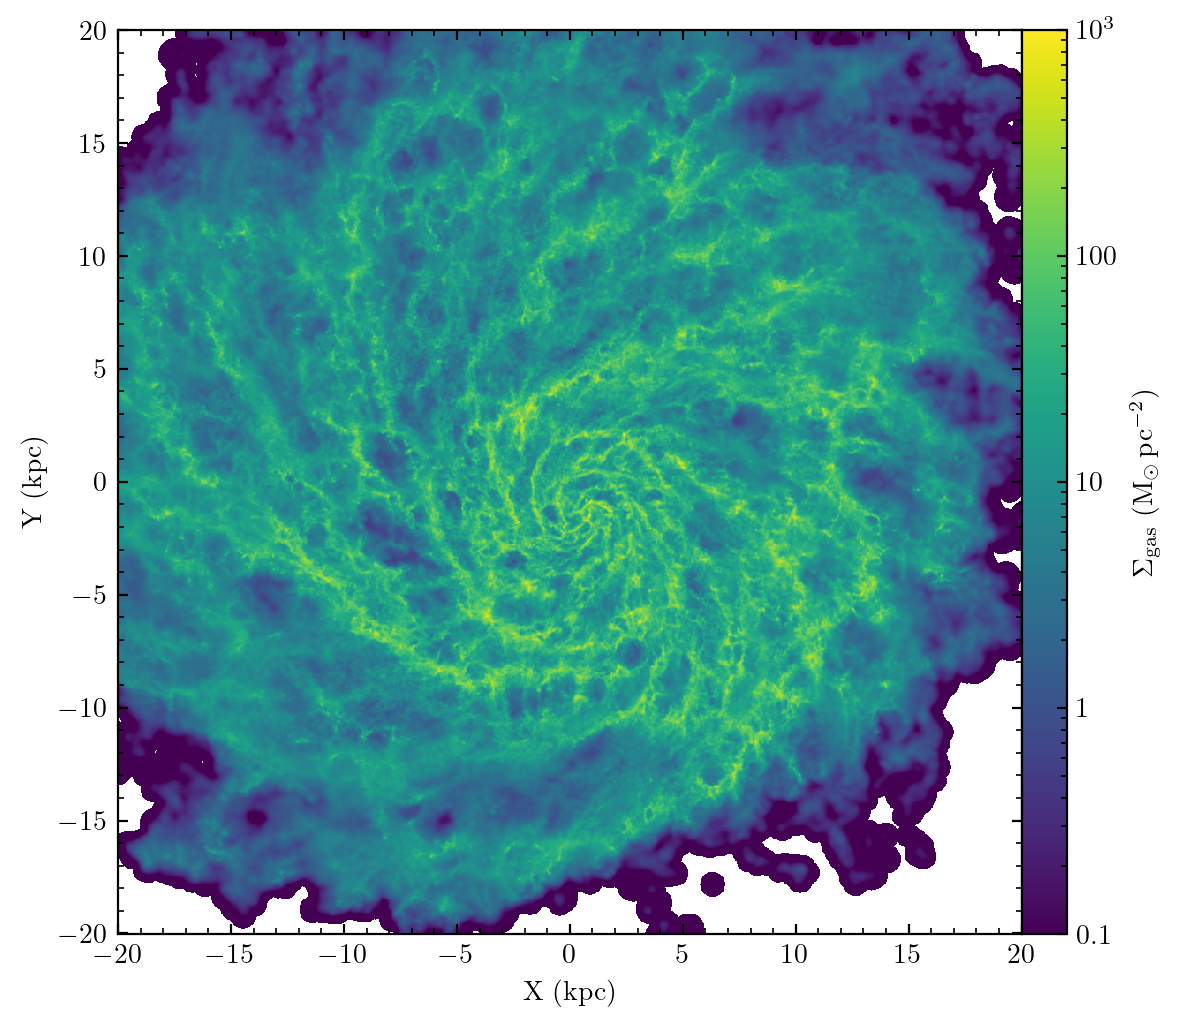

In [18]:
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

M = Meshoid(pos, mass, hsml)
rmax = 20
res = 1024
X = Y = np.linspace(-rmax, rmax, res)
X, Y = np.meshgrid(X, Y, indexing='ij')
fig, ax = plt.subplots(figsize=(6,6))
sigma_gas_msun_pc2 = M.SurfaceDensity(M.m,center=np.array([0,0,0]),size=40.,res=res)*1e4
p = ax.pcolormesh(X, Y, sigma_gas_msun_pc2, norm=colors.LogNorm(vmin=.1,vmax=1e3))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.0)
fig.colorbar(p,label=r"$\Sigma_{\rm gas}$ $(\rm M_\odot\,pc^{-2})$",pad=0,cax=cax)
ax.set_aspect('equal')
ax.set_xlabel("X (kpc)")
ax.set_ylabel("Y (kpc)")
plt.tight_layout(h_pad=1)
plt.show()

Now let's look at the 3D gas density in a slice through the galaxy, using the Slice method. This will reconstruct the data to a grid of points in a plane slicing through the data. You can chose the order of the reconstruction: 0 will simply give the value of the nearest particle (i.e. reflecting the Voronoi domains), 1 will perform a linear reconstruction from that particle, etc. The best order will depend upon the nature of the data: smooth data will look best with higher-order reconstructions, while messier data will have nasty overshoots and artifacts. Here the density field is quite poorly-resolved, so we will use a 0'th order reconstruction.

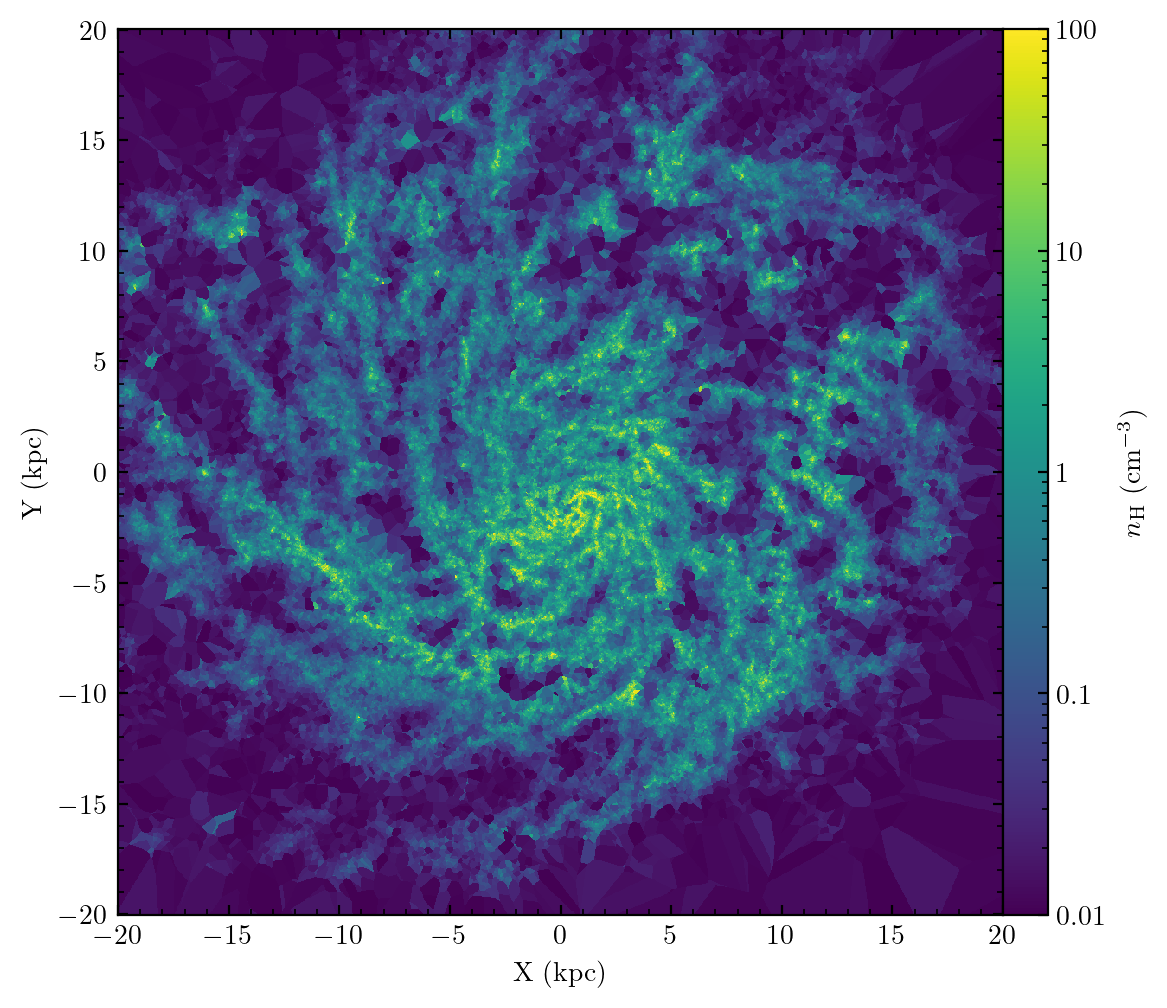

In [19]:
fig, ax = plt.subplots(figsize=(6,6))
density_slice_nHcgs = M.Slice(rho,center=np.array([0,0,0]),size=40.,res=res, order=0) * RHO_TO_NH
# alternative to try: default linear reconstruction of log rho to avoid overshoot to negative density
#density_slice_nHcgs = 10**M.Slice(np.log10(rho),center=np.array([0,0,0]),size=40.,res=res) * RHO_TO_NH
p = ax.pcolormesh(X, Y, density_slice_nHcgs,norm=colors.LogNorm(vmin=.01,vmax=1e2))
ax.set_aspect('equal')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.0)
fig.colorbar(p,label=r"$n_{\rm H}$ $(\rm cm^{-3})$",cax=cax)
ax.set_xlabel("X (kpc)")
ax.set_ylabel("Y (kpc)")
plt.show()

# Simple Radiative Transfer

Meshoid is also capable of performing radiative transfer with a known emissivity/source function and opacity, neglecting scattering. For example, we can load in the stellar positions and assume a simple constant mass-to-light ratio, and calculate the dust-extincted starlight in the V-band.

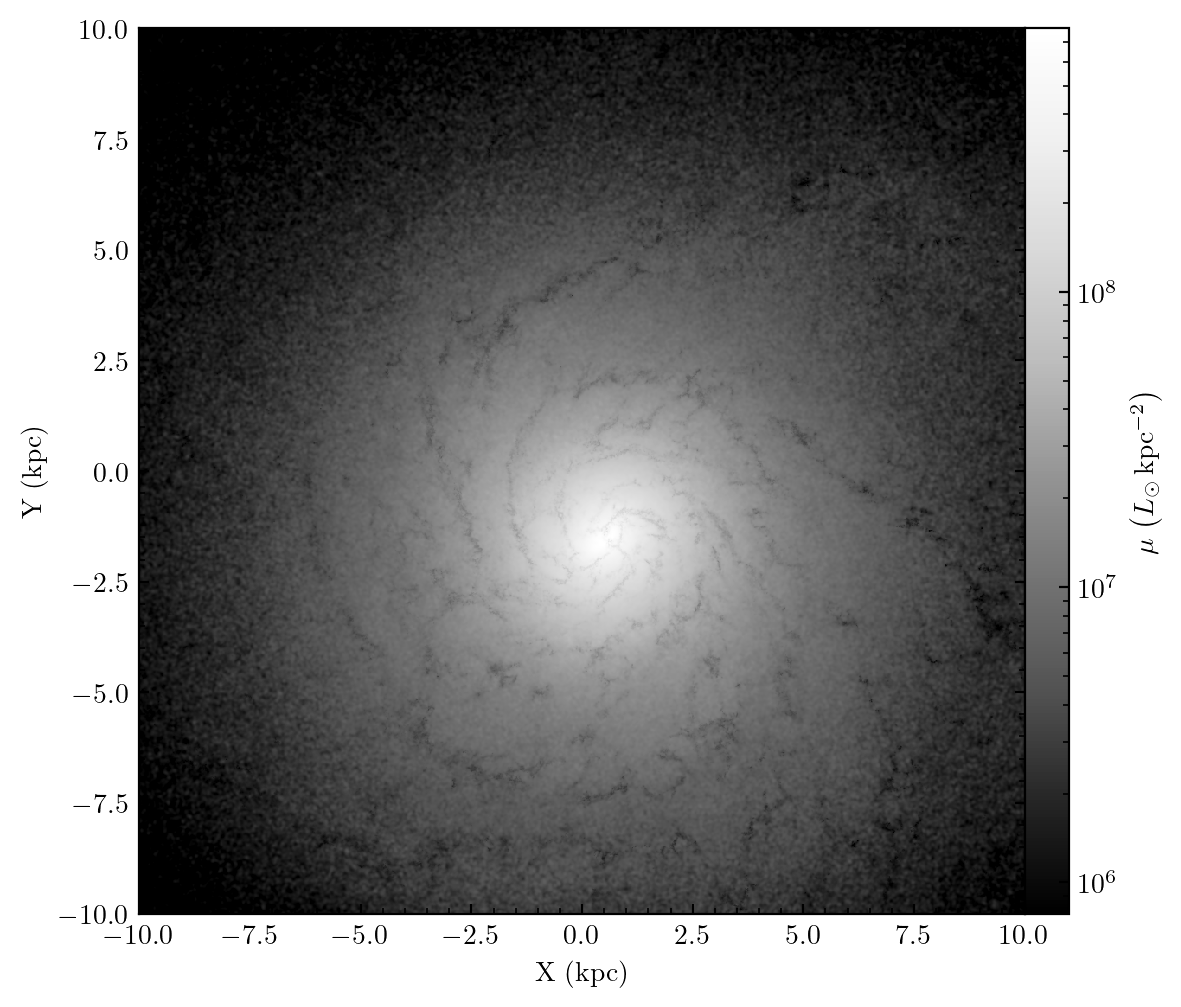

In [20]:
from meshoid.radiation import radtransfer, dust_abs_opacity
from astropy import units as u, constants as c
kappa_dust_codeunits = dust_abs_opacity(0.555) * (u.cm**2/u.g).to(u.kpc**2/(1e10*c.M_sun)) # dust opacity in cgs converted to solar - evaluated at 555nm
kappa_gas = np.repeat(kappa_dust_codeunits,len(mass)) 
j_gas = np.zeros_like(mass) # assume dust does not emit

# have to get the star properties now
x_stars = (load_from_snapshot("Coordinates", 4, ".", 600) - center) @ coordinate_basis
m_stars = load_from_snapshot("Masses", 4, ".", 600)
h_star = np.repeat(0.1, len(m_stars)) # 100pc radii
MASS_TO_LIGHT_SOLAR = 1. # emissivity is just the light-to-mass ratio for stars - here assume 1 (old-ish stellar population in V-band)
j_star = np.repeat(1e10/(MASS_TO_LIGHT_SOLAR), len(m_stars)) # we are assuming a constant emissivity throughout the kernel-smoothed star particles
kappa_stars = np.zeros(len(m_stars))

# now combine all emissivities, opacities, masses, kernel lengths
j_all = np.atleast_2d(np.concatenate([j_gas, j_star])).T # 2D because this has shape (num_particles, num_bands) (can have an arbitrary number of bands)
kappa_all = np.atleast_2d(np.concatenate([kappa_gas, kappa_stars])).T # ditto
kappa_all = kappa_all.clip(1e-100) # we divide by kappa at a certain point so put this to avoid floating-point errors
h_all = np.concatenate([hsml, h_star])
m_all = np.concatenate([mass, m_stars]) 
x_all = np.concatenate([pos,x_stars],axis=0)

rmax = 10
res = 1024
X = Y = np.linspace(-rmax, rmax, res)
X, Y = np.meshgrid(X, Y, indexing='ij')
I = radtransfer(j_all, m_all,kappa_all, x_all,h_all,res,2*rmax) # actual call to rad transfer solver
# screw you I'm not converting this to mag/arcsec^2

fig, ax = plt.subplots(figsize=(6,6))
p = ax.pcolormesh(X,Y, I[:,:,0], norm=colors.LogNorm(vmin=I.max()/1e3, vmax=I.max()), cmap="Greys_r") 
ax.set_aspect('equal')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.0)
fig.colorbar(p,label=r"$\mu\,\left(L_\odot\,\rm kpc^{-2}\right)\, $",cax=cax)
ax.set_xlabel("X (kpc)")
ax.set_ylabel("Y (kpc)")
plt.show()


# Differential Operators

Now let's play around with Meshoid's numerical differentiation. Meshoid can take both first (Meshoid.D) and second derivatives (Meshoid.D2) on unstructured data, using a kernel-weighted (or unweighted) least-squares gradient estimator.

As a first sanity check, we can try differentiating the coordinate functions, with respect to those coordinates. That ought to return an identity matrix. Note that you can differentiate scalars, vectors, or even arbitrary tensors that are defined on the meshoid. In general, differentiating a tensor of rank N will return a tensor of rank N+1.

The first time a given differentiation method is called, Meshoid can take a minute to compute the weights that it needs. Hang in there, Meshoid is working diligently and will re-use those weights the next time you need a derivative!

In [21]:
M.D(pos) 

array([[[ 1.00000000e+00, -1.56125113e-17,  1.56125113e-17],
        [ 2.25080371e-16,  1.00000000e+00, -2.12069945e-16],
        [ 1.30104261e-16, -3.03576608e-16,  1.00000000e+00]],

       [[ 1.00000000e+00, -5.96514483e-17, -1.77402580e-17],
        [-5.62429877e-17,  1.00000000e+00,  8.52725009e-17],
        [ 2.69437792e-16, -8.81591892e-17,  1.00000000e+00]],

       [[ 1.00000000e+00,  4.98157017e-17,  4.32874494e-16],
        [ 4.84079329e-17,  1.00000000e+00, -7.06018902e-17],
        [ 4.68917440e-18,  4.95344868e-17,  1.00000000e+00]],

       ...,

       [[ 1.00000000e+00, -1.60970141e-17, -2.35271871e-17],
        [-3.77099068e-17,  1.00000000e+00,  3.52535113e-17],
        [ 6.46048970e-17, -2.99888627e-16,  1.00000000e+00]],

       [[ 1.00000000e+00, -2.06011965e-16,  1.01874347e-16],
        [-2.15403867e-16,  1.00000000e+00,  9.90893023e-17],
        [ 1.01969214e-16,  5.41396355e-16,  1.00000000e+00]],

       [[ 1.00000000e+00, -7.45388994e-19, -2.98697699e-17],
 

OK now let's look at something physical. Let's calculate the enstrophy, which is just the norm squared of the velocity gradient, and plot it in projection using the ProjectedAverage() method.

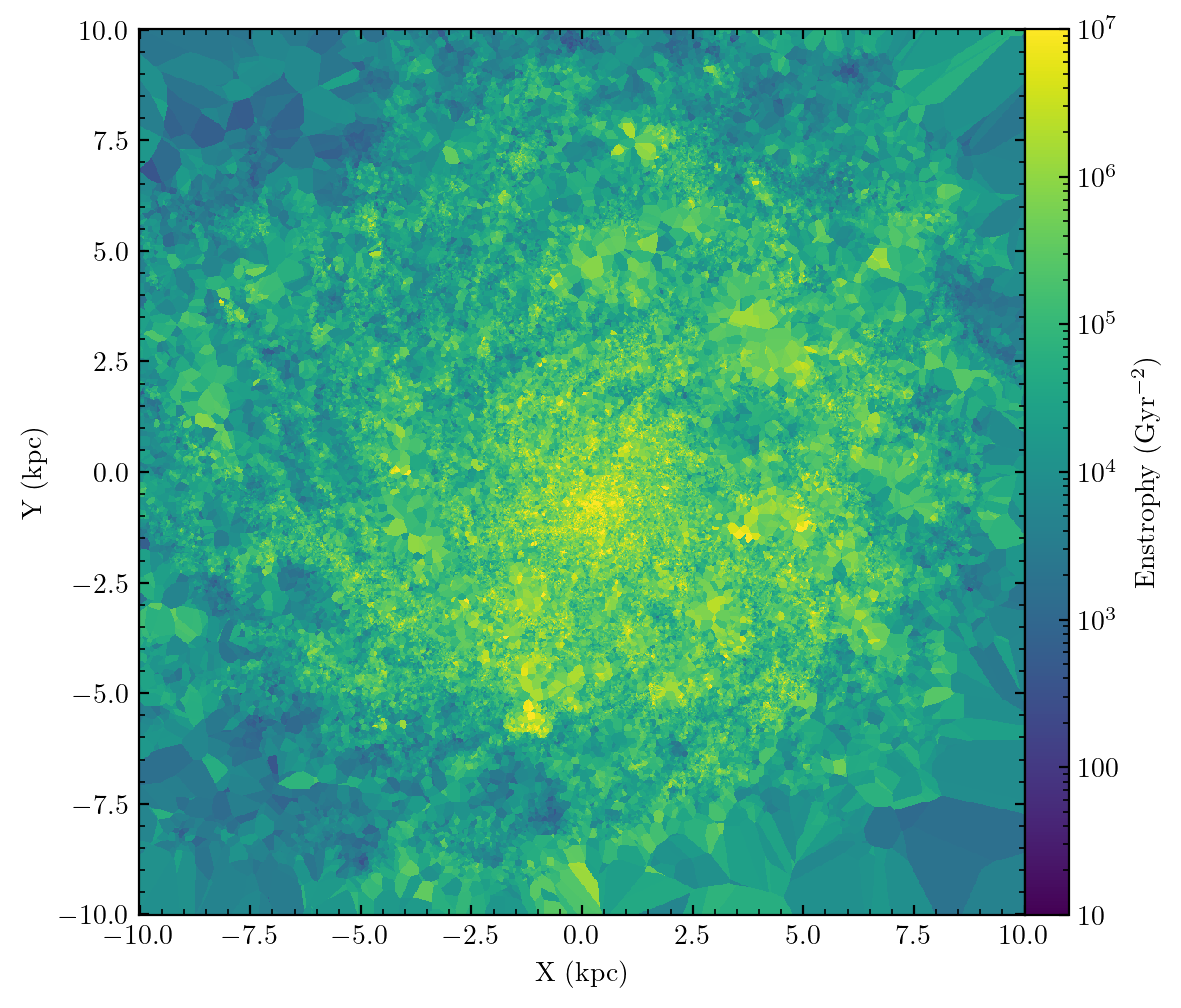

In [22]:
gradv = M.D(v)
enstrophy = np.sum(gradv*gradv, axis=(1,2))
enstrophy_projection = M.Slice(enstrophy,center=np.array([0,0,0]),size=40.,res=res,order=0) # M.ProjectedAverage(enstrophy,center=np.array([0,0,0]),size=40.,res=res)
fig, ax = plt.subplots(figsize=(6,6))
p = ax.pcolormesh(X, Y, enstrophy_projection*.979**2, norm=colors.LogNorm(vmin=10,vmax=1e7))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.0)
fig.colorbar(p,label=r"Enstrophy $(\rm Gyr^{-2})$",cax=cax)
ax.set_aspect('equal')
ax.set_xlabel("X (kpc)")
ax.set_ylabel("Y (kpc)")
plt.show()